# Adaptive Kalman Filtering ($\sigma_k$ method)

Referring to Section 9.1.3.3, consider the problem of tracking a maneuvering target, such as a ship, automobile, aircraft, or ballistic object experiencing atmospheric drag.  While an attempt could be made to model the control inputs, there would be no way to model environmental conditions such as ocean current, wind, and temperature.  A simple approach to this problem would be to increase the process noise variance to take into account the variance in the unknown system dynamics.  While this method does give rise to a nondiverging filter, it is usually far from optimal. A maneuvering target must undergo some type of acceleration.  Therefore, implementing a constant velocity model results in filtered output that does not react quickly to maneuvers and takes a long period of time to recover.  While implementing a constant acceleration model results in filtered output that responds more quickly to maneuvers, this model amplifies the noise and in the residual.

Begin by setting the library path

In [25]:
import lib_path

Set the start time (s), end time (s) and time step (s)

In [26]:
start = 0.0

end = 100.0

step = 0.1

Calculate the number of updates and create the time array with the `linspace` routine from `scipy`

In [27]:
from scipy import linspace

number_of_updates = round( (end - start) / step) + 1

t, dt = linspace(start, end, number_of_updates, retstep=True)

Set the adaptive parameters

In [28]:
n_sigma = 0.08

scale = 1e3

Set the maneuver parameters (time (s) and velocity (m/s))

In [29]:
maneuver_time = 20.0

vmx = 100.0

vmy = 20.0

vmz = 15.0

Set the initial position (m)

In [30]:
px = 2.0

py = 1.0

pz = 5.0

Set the initial velocity (m/s)

In [31]:
vx = 10.0

vy = 20.0

vz = 15.0

Set the measurement noise (m^2) and process variance ( m^2, (m/s)^2, (m/s/s)^2)

In [32]:
measurement_noise_variance = 10.0

process_noise_variance = 1e-6

Create the target trajectory

In [33]:
from scipy import zeros

x_true = zeros([6, number_of_updates])

Add the maneuver

In [34]:
from scipy import ones_like, zeros_like

pre_index = [n for n, e in enumerate(t) if e < maneuver_time]

post_index = [n for n, e in enumerate(t) if e >= maneuver_time]



x = px + vx * t[pre_index]

xm = x[-1] + vmx * (t[post_index] - maneuver_time)



y = py + vy * t[pre_index]

ym = y[-1] + vmy * (t[post_index] - maneuver_time)



z = pz + vz * t[pre_index]

zm = z[-1] + vmz * (t[post_index] - maneuver_time)



x_true[0] = [*x, *xm]

x_true[1] = [*(vx * ones_like(t[pre_index])), *(vmx * ones_like(t[post_index]))]

x_true[2] = [*y, *ym]

x_true[3] = [*(vy * ones_like(t[pre_index])), *(vmy * ones_like(t[post_index]))]

x_true[4] = [*z, *zm]

x_true[5] = [*(vz * ones_like(t[pre_index])), *(vmz * ones_like(t[post_index]))]

Set up the measurement noise

In [35]:
from scipy import sqrt, random

v = sqrt(measurement_noise_variance) * (random.rand(number_of_updates) - 0.5)

Initialize state and input control vector

In [36]:
x = zeros(6)

u = zeros_like(x)

Initialize the covariance and control matrix

In [37]:
from scipy import eye

P = 1.0e3 * eye(6)

B = zeros_like(P)

Initialize measurement and process noise variance

In [38]:
R = measurement_noise_variance * eye(3)

Q = process_noise_variance * eye(6)

State transition and measurement transition

In [39]:
A = eye(6)

A[0, 1] = dt

A[2, 3] = dt

A[4, 5] = dt

Measurement transition matrix

In [40]:
H = zeros([3, 6])

H[0, 0] = 1

H[1, 2] = 1

H[2, 4] = 1

Initialize the Kalman filter

In [41]:
from Libs.tracking import kalman

kf = kalman.Kalman(x, u, P, A, B, Q, H, R)

Generate the measurements

In [42]:
from scipy import matmul

z = [matmul(H, x_true[:, i]) + v[i] for i in range(number_of_updates)]

Update the filter for each measurement

In [43]:
kf.filter_sigma(z, n_sigma, scale)

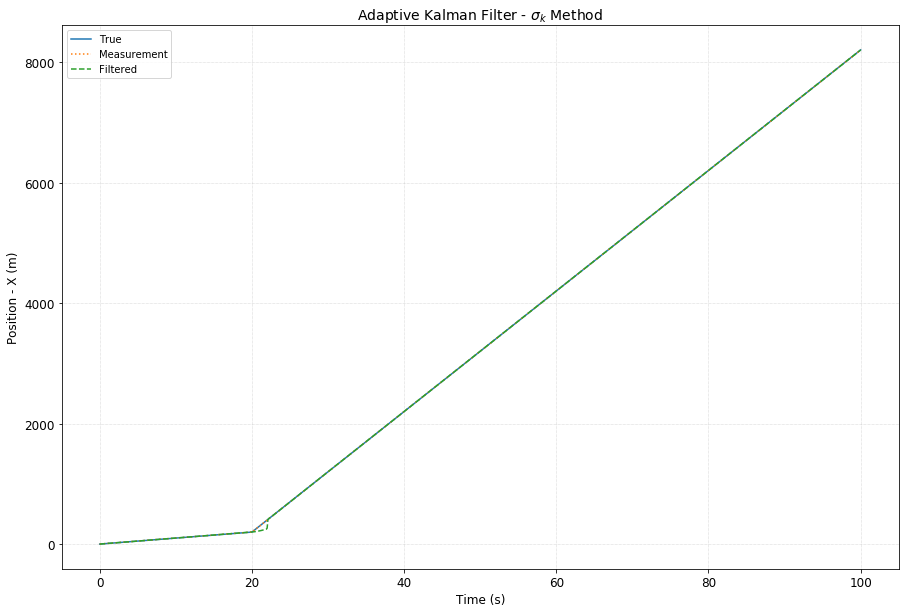

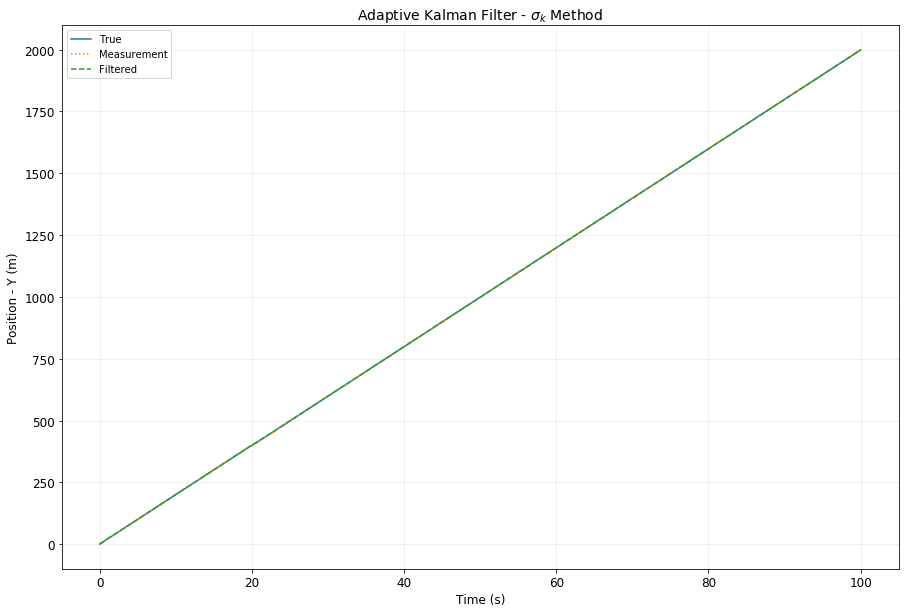

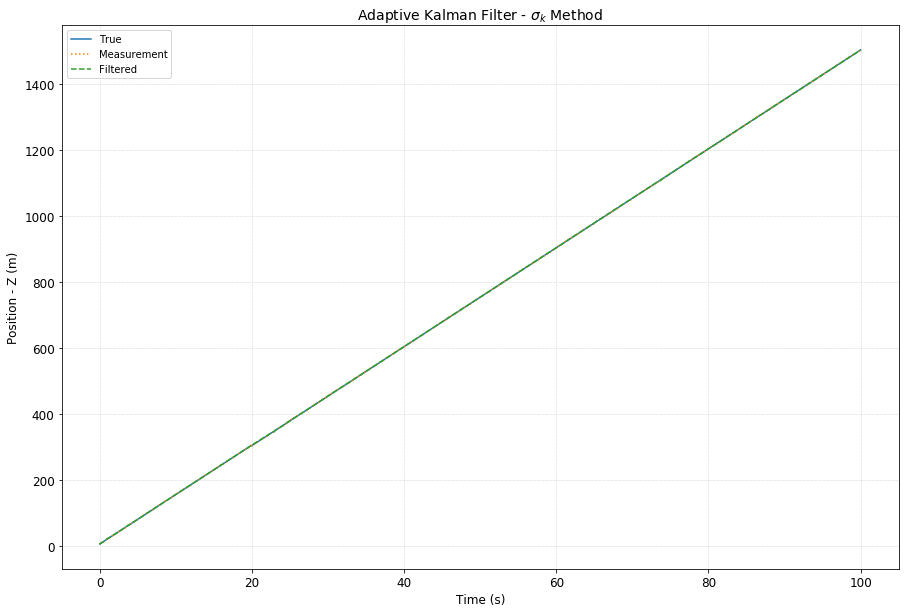

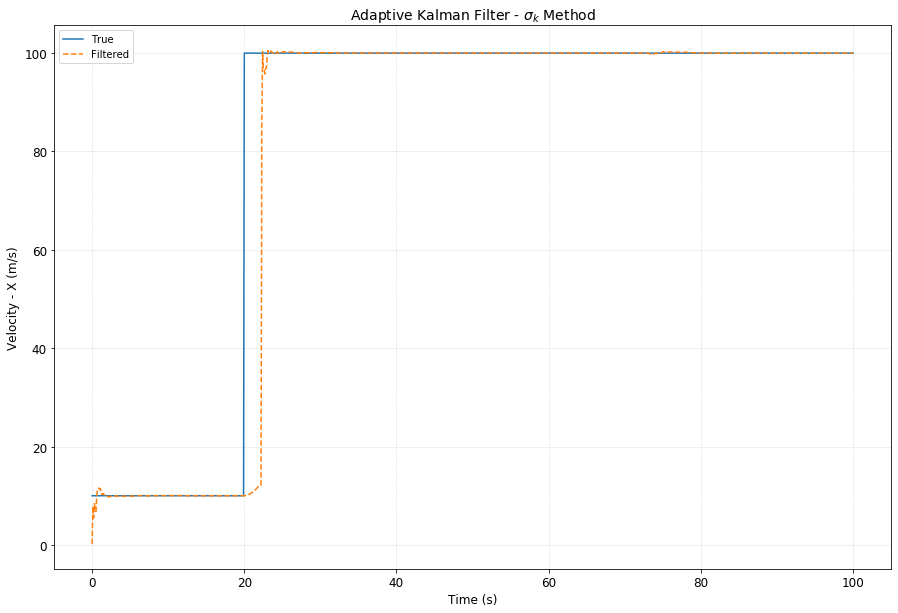

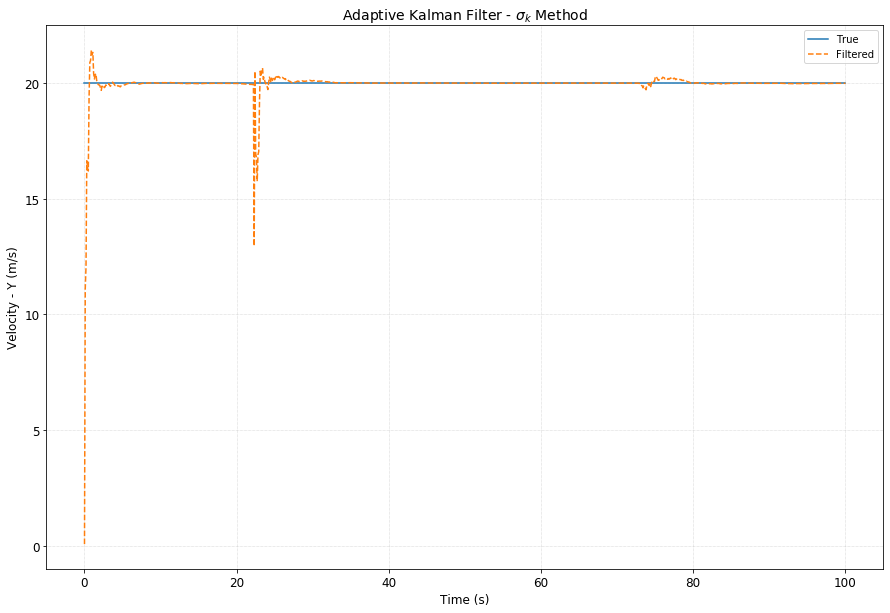

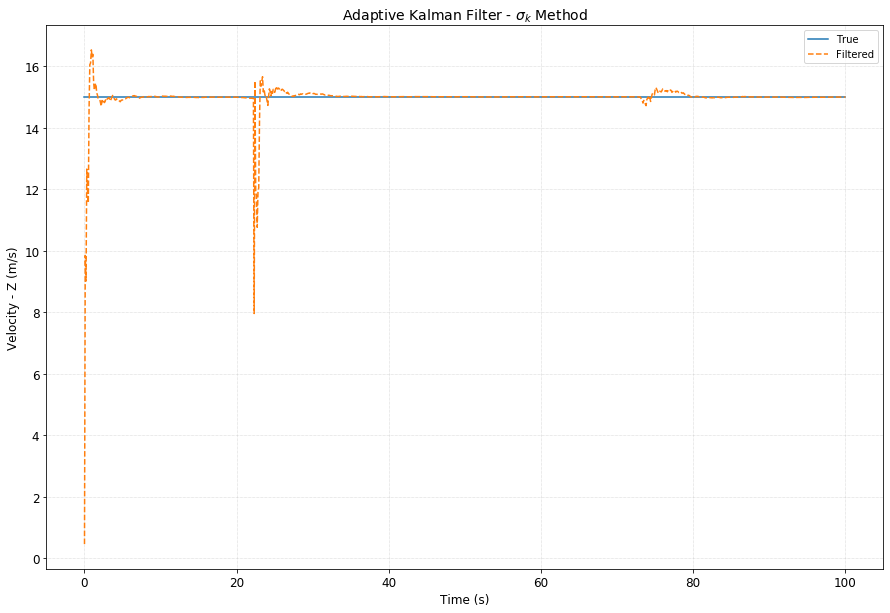

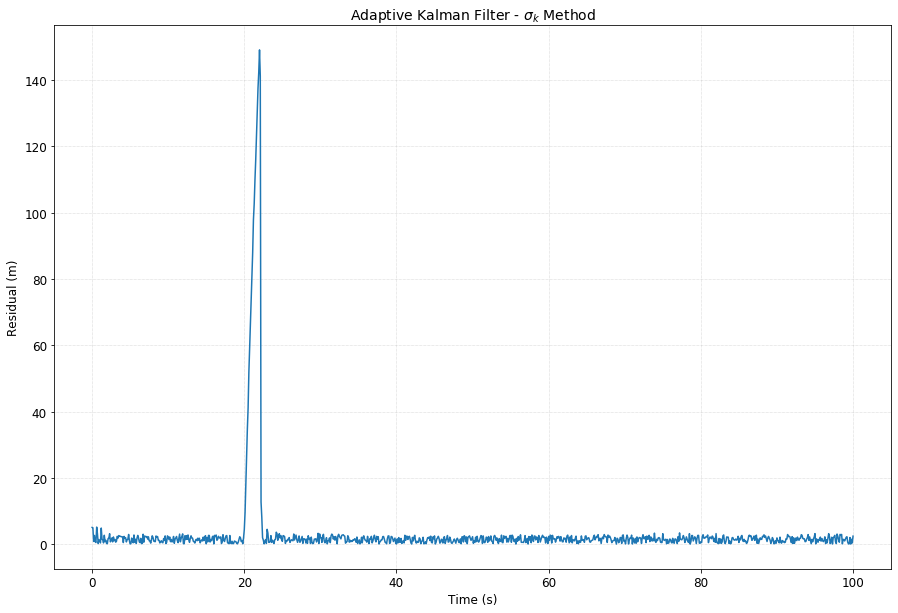

In [44]:
from matplotlib import pyplot as plt


# Set the figure size

plt.rcParams["figure.figsize"] = (15, 10)



# Position - X

plt.figure()

plt.plot(t, x_true[0, :], '', label='True')

plt.plot(t, [z[0] for z in z], ':', label='Measurement')

plt.plot(t, [x[0] for x in kf.state], '--', label='Filtered')

plt.ylabel('Position - X (m)', size=12)

plt.legend(loc='best', prop={'size': 10})

# Set the plot title and labels

plt.title('Adaptive Kalman Filter - $\sigma_k$ Method', size=14)

plt.xlabel('Time (s)', size=12)


# Set the tick label size

plt.tick_params(labelsize=12)


# Turn on the grid

plt.grid(linestyle=':', linewidth=0.5)



# Position - Y

plt.figure()

plt.plot(t, x_true[2, :], '', label='True')

plt.plot(t, [z[1] for z in z], ':', label='Measurement')

plt.plot(t, [x[2] for x in kf.state], '--', label='Filtered')

plt.ylabel('Position - Y (m)', size=12)

plt.legend(loc='best', prop={'size': 10})

# Set the plot title and labels

plt.title('Adaptive Kalman Filter - $\sigma_k$ Method', size=14)

plt.xlabel('Time (s)', size=12)


# Set the tick label size

plt.tick_params(labelsize=12)


# Turn on the grid

plt.grid(linestyle=':', linewidth=0.5)



# Position - Z

plt.figure()

plt.plot(t, x_true[4, :], '', label='True')

plt.plot(t, [z[2] for z in z], ':', label='Measurement')

plt.plot(t, [x[4] for x in kf.state], '--', label='Filtered')

plt.ylabel('Position - Z (m)', size=12)

plt.legend(loc='best', prop={'size': 10})

# Set the plot title and labels

plt.title('Adaptive Kalman Filter - $\sigma_k$ Method', size=14)

plt.xlabel('Time (s)', size=12)


# Set the tick label size

plt.tick_params(labelsize=12)


# Turn on the grid

plt.grid(linestyle=':', linewidth=0.5)



# Velocity - X

plt.figure()

plt.plot(t, x_true[1, :], '', label='True')

plt.plot(t, [x[1] for x in kf.state], '--', label='Filtered')

plt.ylabel('Velocity - X (m/s)', size=12)

plt.legend(loc='best', prop={'size': 10})

# Set the plot title and labels

plt.title('Adaptive Kalman Filter - $\sigma_k$ Method', size=14)

plt.xlabel('Time (s)', size=12)


# Set the tick label size

plt.tick_params(labelsize=12)


# Turn on the grid

plt.grid(linestyle=':', linewidth=0.5)



# Velocity - Y

plt.figure()

plt.plot(t, x_true[3, :], '', label='True')

plt.plot(t, [x[3] for x in kf.state], '--', label='Filtered')

plt.ylabel('Velocity - Y (m/s)', size=12)

plt.legend(loc='best', prop={'size': 10})

# Set the plot title and labels

plt.title('Adaptive Kalman Filter - $\sigma_k$ Method', size=14)

plt.xlabel('Time (s)', size=12)


# Set the tick label size

plt.tick_params(labelsize=12)


# Turn on the grid

plt.grid(linestyle=':', linewidth=0.5)



# Velocity - Z

plt.figure()

plt.plot(t, x_true[5, :], '', label='True')

plt.plot(t, [x[5] for x in kf.state], '--', label='Filtered')

plt.ylabel('Velocity - Z (m/s)', size=12)

plt.legend(loc='best', prop={'size': 10})

# Set the plot title and labels

plt.title('Adaptive Kalman Filter - $\sigma_k$ Method', size=14)

plt.xlabel('Time (s)', size=12)


# Set the tick label size

plt.tick_params(labelsize=12)


# Turn on the grid

plt.grid(linestyle=':', linewidth=0.5)



# Residual

plt.figure()

plt.plot(t, kf.residual, '')

plt.ylabel('Residual (m)', size=12)



# Set the plot title and labels

plt.title('Adaptive Kalman Filter - $\sigma_k$ Method', size=14)

plt.xlabel('Time (s)', size=12)


# Set the tick label size

plt.tick_params(labelsize=12)


# Turn on the grid

plt.grid(linestyle=':', linewidth=0.5)